In [120]:
import PIL
if not hasattr(PIL, "PILLOW_VERSION"):
    PIL.PILLOW_VERSION = PIL.__version__
import torch
from pathlib import Path
from torch import nn, optim
from torchvision import transforms, datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [125]:
import importlib
import AE # your python file (mymodule.py)
importlib.reload(AE)

<module 'AE' from 'c:\\Users\\burha\\Python Projects\\CSCC11\\C11-Group-7-Project\\AE.py'>

In [2]:
star_folder_dir = "data\\star"
galaxy_folder_dir = "data\\galaxy"
star_images = Path(star_folder_dir).glob("*")
galaxy_images = Path(galaxy_folder_dir).glob("*")
star_list = []    
for image in star_images:
    img = PIL.Image.open(image).convert("L")
    star_list.append(np.array(img).reshape(-1))
star_array = np.array(star_list)
galaxy_list = []    
for image in galaxy_images:
    img = PIL.Image.open(image).convert("L")
    galaxy_list.append(np.array(img).reshape(-1))
galaxy_array = np.array(galaxy_list)


In [3]:
dataset_array = np.concat([star_array, galaxy_array])
dataset_array.shape

(3986, 4096)

In [127]:
tensor_transform = transforms.ToTensor()
dataset = dataset_array
loader = torch.utils.data.DataLoader(
    dataset=dataset, batch_size=128, shuffle=True)




In [126]:
model = AE.AE()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Epoch 1/30, Loss: 0.020429
Epoch 2/30, Loss: 0.018756
Epoch 3/30, Loss: 0.016272
Epoch 4/30, Loss: 0.014940
Epoch 5/30, Loss: 0.016165
Epoch 6/30, Loss: 0.017441
Epoch 7/30, Loss: 0.017462
Epoch 8/30, Loss: 0.014456
Epoch 9/30, Loss: 0.016631
Epoch 10/30, Loss: 0.017420
Epoch 11/30, Loss: 0.016034
Epoch 12/30, Loss: 0.015035
Epoch 13/30, Loss: 0.015145
Epoch 14/30, Loss: 0.014550
Epoch 15/30, Loss: 0.015528
Epoch 16/30, Loss: 0.013992
Epoch 17/30, Loss: 0.014088
Epoch 18/30, Loss: 0.014348
Epoch 19/30, Loss: 0.014343
Epoch 20/30, Loss: 0.013943
Epoch 21/30, Loss: 0.014394
Epoch 22/30, Loss: 0.016306
Epoch 23/30, Loss: 0.014629
Epoch 24/30, Loss: 0.016186
Epoch 25/30, Loss: 0.014916
Epoch 26/30, Loss: 0.015752
Epoch 27/30, Loss: 0.015815
Epoch 28/30, Loss: 0.013533
Epoch 29/30, Loss: 0.015814
Epoch 30/30, Loss: 0.013561


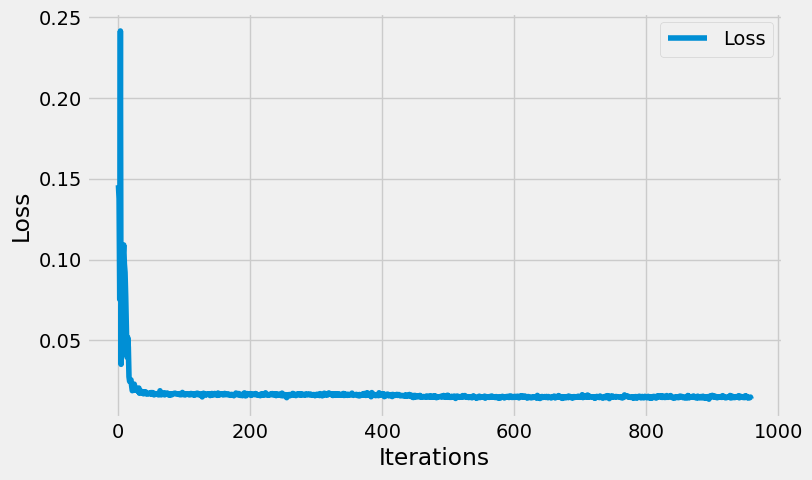

In [128]:
epochs = 30
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(epochs):
    for images in loader:
        images = images.float() / 255
        images = images.view(-1, 64 * 64).to(device)
        
        reconstructed = model(images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

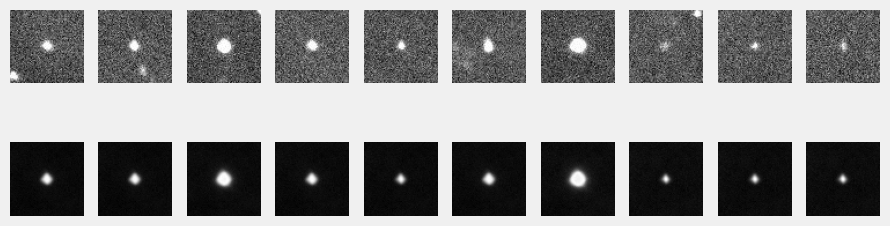

In [129]:
model.eval()
dataiter = iter(loader)
images = next(dataiter)

images = images.float() / 255
images = images.view(-1, 64 * 64).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(64, 64), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(64, 64), cmap='gray')
    axes[1, i].axis('off')
plt.show()

In [130]:
star_df = pd.DataFrame(star_array)
star_df["TYPE"] = 1
galaxy_df = pd.DataFrame(galaxy_array)
galaxy_df["TYPE"] = 0
df = pd.concat([star_df, galaxy_df]).sample(frac=1, ignore_index=True, random_state=101290365)


In [131]:
X_total = df.drop("TYPE", axis=1)
y = df["TYPE"]
X_total = X_total / float(255)

In [132]:
X_np = X_total.to_numpy().astype(np.float32)
X_tensor = torch.from_numpy(X_np).to(device)  # move to GPU if available
model.eval()
with torch.no_grad():
    X = model.encoder(X_tensor)  # shape: (3900, 64)
X

tensor([[-0.0262, -0.6428, -0.0150,  ..., -0.0395, -0.1374,  0.4865],
        [ 0.0018, -0.6671, -0.0015,  ..., -0.0256, -0.1980,  0.3396],
        [-0.0183, -0.5252, -0.0087,  ..., -0.0225, -0.1122,  0.3922],
        ...,
        [-0.0101, -0.5327, -0.0041,  ..., -0.0173, -0.1266,  0.3522],
        [ 0.0111, -0.6813, -0.0016,  ..., -0.0166, -0.2276,  0.2870],
        [-0.0521, -0.6498, -0.0241,  ..., -0.0486, -0.1111,  0.5835]])

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [134]:
torch.save(model.state_dict(), "model.pth")


Fitting GLM with Autoencoder

In [138]:
glm = LogisticRegression(solver="newton-cholesky")
glm.fit(X_train, y_train)
preds = glm.predict(X_test)
1 - (preds - y_test).mean()

np.float64(0.7744360902255639)